In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from abc import ABC, abstractmethod

In [3]:
class RBFcovariance(ABC, tf.keras.Model):
    """
    General RBF-type covariance of the form
        
        k(x1, x2) = k(||x1 - x2||)
        
    for some ||.|| norm. Example members of this family are
    
        - Exponentiated Quadratic (EQ)
        - Laplace
        - Cauchy
        - Matern
        
    This abstract base class requires the functions `norm` and `sample_rff`
    to be specified. 
    """

    def __init__(self, 
                 log_coeff,
                 log_scales,
                 dim,
                 dtype,
                 name='eq_covariance',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
    
        # Convert parameters to tensors
        log_coeff = tf.convert_to_tensor(log_coeff, dtype=dtype)
        log_scales = tf.convert_to_tensor(log_scales, dtype=dtype)

        # Reshape parameter tensors
        log_coeff = tf.squeeze(log_coeff)
        log_scales = tf.reshape(log_scales, (-1,))
        
        # Set input dimensionality
        self.dim = dim
        
        # Set EQ parameters
        self.log_scales = tf.Variable(log_scales)
        self.log_coeff = tf.Variable(log_coeff)
        
        
    @property
    def scales(self):
        return tf.math.exp(self.log_scales)
    
    
    @property
    def coeff(self):
        return tf.math.exp(self.log_coeff)
    
    
    @abstractmethod
    def norm(self):
        return
    
    
    @abstractmethod
    def sample_omega(self, x, num_features):
        pass
    
    
    def sample_rff_functions(self, x, num_samples, num_features):
        
        # Sample omegas of the Fourier features
        omega = self.sample_omega(num_samples=num_samples,
                                  num_features=num_features)

        # Scale omegas by lengthscale -- same operation for all rbf kernels
        omega = omega / self.scales[None, None, :]

        # Sample phase shifts phi of the Fourier features
        phi = np.random.uniform(low=0.,
                                high=(2 * np.pi),
                                size=(num_functions, num_features, 1))

        
        features = np.cos(np.einsum('sfd, nd -> sfn', omega, x) + phi)
        features = (2 / num_features) ** 0.5 * features * coefficient

        functions = np.einsum('sf, sfn -> sn', weights, features)

        return functions, features
    
        
    def __call__(self,
                 x1,
                 x2,
                 diag=False,
                 epsilon=None):
        
        # Convert to tensors
        x1 = tf.convert_to_tensor(x1, dtype=self.dtype)
        x2 = tf.convert_to_tensor(x2, dtype=self.dtype)

        # Get vector of lengthscales
        scales = self.scales
        
        # If calculating full covariance, add dimensions to broadcast
        if not diag:

            x1 = x1[:, None, :]
            x2 = x2[None, :, :]

            scales = self.scales[None, None, :]

        # Compute quadratic, exponentiate and multiply by coefficient
        cov = self.coeff ** 2 * self.rbf((x1 - x2) / scales)
        
        # Add jitter for invertibility
        if epsilon is not None:
            cov = cov + epsilon * tf.eye(cov.shape[0], dtype=self.dtype)

        return cov

In [262]:
import tensorflow as tf
import tensorflow_probability as tfp


class ConstantMean(tf.keras.Model):

    def __init__(self,
                 dtype,
                 name='constant_mean'):
        
        super().__init__(name=name, dtype=dtype)
        
        self.constant = tf.convert_to_tensor(tf.constant(0., dtype=dtype))
        
        
    def __call__(self, x):
        return self.constant * tf.ones(x.shape[0], dtype=self.dtype)
    
    
class EQcovariance(tf.keras.Model):

    def __init__(self, 
                 log_coeff,
                 log_scales,
                 dim,
                 dtype,
                 name='eq_covariance',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
    
        # Convert parameters to tensors
        log_coeff = tf.convert_to_tensor(log_coeff, dtype=dtype)
        log_scales = tf.convert_to_tensor(log_scales, dtype=dtype)

        # Reshape parameter tensors
        log_coeff = tf.squeeze(log_coeff)
        log_scales = tf.reshape(log_scales, (-1,))
        
        # Set input dimensionality
        self.dim = dim
        
        # Set EQ parameters
        self.log_scales = tf.Variable(log_scales)
        self.log_coeff = tf.Variable(log_coeff)
        
        
    def __call__(self,
                 x1,
                 x2,
                 diag=False,
                 epsilon=None):
        
        # Convert to tensors
        x1 = tf.convert_to_tensor(x1, dtype=self.dtype)
        x2 = tf.convert_to_tensor(x2, dtype=self.dtype)

        # Get vector of lengthscales
        scales = self.scales
        
        # If calculating full covariance, add dimensions to broadcast
        if not diag:

            x1 = x1[:, None, :]
            x2 = x2[None, :, :]

            scales = self.scales[None, None, :] ** 2

        # Compute quadratic, exponentiate and multiply by coefficient
        quad = - 0.5 * (x1 - x2) ** 2 / scales
        quad = tf.reduce_sum(quad, axis=-1)
        eq_cov = self.coeff ** 2 * tf.exp(quad)
        
        # Add jitter for invertibility
        if epsilon is not None:
            eq_cov = eq_cov + epsilon * tf.eye(eq_cov.shape[0], 
                                               dtype=self.dtype)

        return eq_cov
        
    
    @property
    def scales(self):
        return 1. + 0. * tf.math.exp(self.log_scales)
    
    
    @property
    def coeff(self):
        return 1. + 0. * tf.math.exp(self.log_coeff)

In [263]:
# Set random seed and tf.dtype
np.random.seed(0)
dtype = tf.float64

# Num. observations (N)
N = 100

# EQ covariance hyperparameters
log_coeff = 0.
log_scale = 0.
noise = 1e-1
dim = 1

# Initialise covariance
ground_truth_cov = EQcovariance(log_coeff=log_coeff,
                                log_scales=log_scale,
                                dim=dim,
                                dtype=dtype)

# Pick inputs at random
x_train = np.random.uniform(low=-4., high=4., size=(N, 1))

# Compute covariance matrix terms
K_train_train = ground_truth_cov(x_train, x_train, epsilon=1e-12)
I_noise = noise ** 2 * np.eye(N)

# Sample f_ind | x_ind
y_train = np.dot(np.linalg.cholesky(K_train_train + I_noise),
                 np.random.normal(loc=0., scale=1., size=(N, 1)))

# Locations to plot mean and variance of generative model, y_plot | f_ind, x_plot
x_plot = np.linspace(-8., 8., 100)[:, None]

# Covariances between inducing points and input locations
K_train_plot = ground_truth_cov(x_train, x_plot)
K_plot_train = ground_truth_cov(x_plot, x_train)
K_plot_diag = ground_truth_cov(x_plot, x_plot, diag=True)

# Mean and standard deviation of y_plot | f_ind, x_plot
y_plot_mean = np.dot(K_plot_train, np.linalg.solve(K_train_train + I_noise, y_train))[:, 0]
f_plot_var = K_plot_diag - np.diag(np.dot(K_plot_train,
                                   np.linalg.solve(K_train_train + I_noise, K_train_plot)))
y_plot_var = f_plot_var + noise ** 2
y_plot_std = y_plot_var ** 0.5

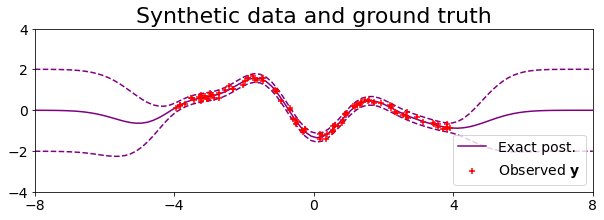

In [264]:
# Plot inducing points and observed data
plt.figure(figsize=(10, 3))
    
# Plot exact posterior predictive
plt.plot(x_plot, y_plot_mean - 2*y_plot_std, '--', color='purple',  zorder=2)
plt.plot(x_plot, y_plot_mean, color='purple',  zorder=2, label='Exact post.')
plt.plot(x_plot, y_plot_mean + 2*y_plot_std, '--', color='purple',  zorder=2)

# Plot sampled data
plt.scatter(x_train,
            y_train,
            color='red',
            marker='+',
            zorder=3,
            label=r'Observed $\mathbf{y}$')

# Plot formatting
plt.title('Synthetic data and ground truth', fontsize=22)
plt.xticks(np.linspace(-8, 8, 5), fontsize=14)
plt.yticks(np.linspace(-4, 4, 5), fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.xlim([-8., 8.])
plt.show()

In [265]:
def plot(model,
         ground_truth_cov,
         x_pred,
         x_train,
         y_train,
         x_ind_init,
         step):

    # Get exact and approximate posterior predictive
    vfe_mean, vfe_var = model.post_pred(x_pred)

    # Covariances between inducing points and input locations
    K_train_plot = ground_truth_cov(x_train, x_plot)
    K_plot_train = ground_truth_cov(x_plot, x_train)
    K_plot_diag = ground_truth_cov(x_plot, x_plot, diag=True)

    # Mean and standard deviation of y_plot | f_ind, x_plot
    exact_mean = np.dot(K_plot_train, np.linalg.solve(K_train_train + I_noise,
                                                      y_train))[:, 0]
    exact_var = K_plot_diag - np.diag(np.dot(K_plot_train,
                                       np.linalg.solve(K_train_train + I_noise,
                                                       K_train_plot)))
    exact_std = (exact_var + noise ** 2) ** 0.5
    
    x_pred = x_pred[:, 0].numpy()
    x_ind = model.x_ind[:, 0].numpy()
    
    vfe_mean = vfe_mean.numpy()
    vfe_var = vfe_var.numpy()
    
    plt.figure(figsize=(8, 3))
    
    # Plot posterior predictive
    plt.plot(x_pred,
             vfe_mean,
             color='black',
             zorder=1,
             label='Approx. Post.')
    
    plt.fill_between(x_pred,
                     vfe_mean - 2 * vfe_var ** 0.5,
                     vfe_mean + 2 * vfe_var ** 0.5,
                     color='gray',
                     alpha=0.3)
    
    # Plot exact posterior
    plt.plot(x_plot,
             exact_mean - 2*exact_std,
             '--',
             color='purple',
             zorder=1)
    
    plt.plot(x_plot,
             exact_mean,
             color='purple',
             zorder=1)
    
    plt.plot(x_plot,
             exact_mean + 2*exact_std,
             '--',
             color='purple',
             zorder=1,
             label='Exact Post.')

    # Plot training data
    plt.scatter(x_train, y_train, color='red', marker='+', zorder=2)
    
    # Plot initial inducing points
    plt.scatter(x_ind_init,
                -5.5 * tf.ones_like(x_ind_init),
                color='green',
                marker='+',
                label=r'Init. $\bar{\mathbf{X}}$',
                zorder=2)
    
    # Plot current inducing points
    plt.scatter(x_ind,
                -5. * tf.ones_like(x_ind),
                color='blue',
                marker='+',
                label=r'Curr. $\bar{\mathbf{X}}$',
                zorder=2)
    
    sample = model.sample_posterior(num_samples=num_samples)

    plt.scatter(model.x_ind[:, 0], sample[:, 0], marker='o', s=100, color='k')
    
    # Format plot
    plt.title(f'VFE after {step} optimisation steps', fontsize=18)
    
#     plt.xticks(np.arange(-10, 11, 4), fontsize=14)
#     plt.yticks(np.arange(-6, 7, 3), fontsize=14)
    
#     plt.xlim([-8., 8.])
#     plt.ylim([-8., 4.])
    
    plt.legend(loc='lower right', fontsize=10)
    
    plt.show()
    
    
def print_info(model, step):
    
    free_energy = model.free_energy()
    print(f'Step: {step:5>} '
          f'Free energy: {free_energy.numpy():8.3f} '
          f'Coeff: {model.cov.coeff.numpy():5.2f} '
          f'Scales: {[round(num, 3) for num in model.cov.scales.numpy()]} '
          f'Noise: {model.noise.numpy():5.2f}')

In [266]:
class VFEGP(tf.keras.Model):
    
    def __init__(self,
                 x_train,
                 y_train,
                 x_ind_init,
                 mean,
                 cov,
                 log_noise,
                 dtype,
                 name='vfe_gp',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
        
        # Set training data and inducing point initialisation
        self.x_train = tf.convert_to_tensor(x_train, dtype=dtype)
        self.y_train = tf.convert_to_tensor(y_train, dtype=dtype)
        
        # Set inducing points
        self.x_ind = tf.convert_to_tensor(x_ind_init, dtype=dtype)
        self.x_ind = tf.Variable(self.x_ind)
        
        # Set mean and covariance functions
        self.mean = mean
        self.cov = cov
    
        # Set log of noise parameter
        self.log_noise = tf.convert_to_tensor(log_noise,
                                              dtype=dtype)
        self.log_noise = tf.Variable(self.log_noise)
        
        
    def post_pred(self, x_pred):
        
        # Number of training points
        N = self.y_train.shape[0]
        M = self.x_ind.shape[0]
        
        # Compute covariance terms
        K_ind_ind = self.cov(self.x_ind, self.x_ind, epsilon=1e-4)
        K_train_ind = self.cov(self.x_train, self.x_ind)
        K_ind_train = self.cov(self.x_ind, self.x_train)
        K_pred_ind = self.cov(x_pred, self.x_ind)
        K_ind_pred = self.cov(self.x_ind, x_pred)
        K_pred_pred_diag = self.cov(x_pred, x_pred, diag=True)
        
        # Compute shared matrix and its cholesky:
        # L = chol(K_ind_ind)
        # U = iL K_ind_train
        # A = U / noise
        # B = I + A A.T
        L = tf.linalg.cholesky(K_ind_ind)
        LT = tf.transpose(L, (1, 0))
        U = tf.linalg.triangular_solve(L, K_ind_train, lower=True)
        A = U / self.noise
        B = tf.eye(M, dtype=self.dtype) + tf.matmul(A, A, transpose_b=True)
        B_chol = tf.linalg.cholesky(B)
        
        # Compute mean
        diff = self.y_train # - self.mean(self.x_train)[:, None]
        beta = tf.linalg.cholesky_solve(B_chol, tf.matmul(U, diff))
        beta = tf.linalg.triangular_solve(LT, beta, lower=False)
        mean = tf.matmul(K_pred_ind / self.noise ** 2, beta)[:, 0]
        
        C = tf.linalg.triangular_solve(L, K_ind_pred)
        D = tf.linalg.triangular_solve(B_chol, C)
        
        # Compute variance
        var = K_pred_pred_diag + self.noise ** 2
        var = var - tf.linalg.diag_part(tf.matmul(C, C, transpose_a=True))
        var = var + tf.linalg.diag_part(tf.matmul(D, D, transpose_a=True))
        
        return mean, var
        
        
    def free_energy(self):
        
        # Number of training points
        N = self.y_train.shape[0]
        M = self.x_ind.shape[0]
        
        # Compute covariance terms
        K_ind_ind = self.cov(self.x_ind, self.x_ind, epsilon=1e-6)
        K_train_ind = self.cov(self.x_train, self.x_ind)
        K_ind_train = self.cov(self.x_ind, self.x_train)
        K_train_train = self.cov(self.x_train, self.x_train)
        
        # Compute shared matrix and its cholesky:
        # L = chol(K_ind_ind)
        # U = iL K_ind_train
        # A = U / noise
        # B = I + A A.T
        L = tf.linalg.cholesky(K_ind_ind)
        U = tf.linalg.triangular_solve(L, K_ind_train, lower=True)
        A = U / self.noise
        B = tf.eye(M, dtype=self.dtype) + tf.matmul(A, A, transpose_b=True)
        B_chol = tf.linalg.cholesky(B)
        
        # Compute log-normalising constant of the matrix
        log_pi = - N / 2 * tf.math.log(tf.constant(2 * np.pi, dtype=self.dtype))
        log_det_B = - tf.reduce_sum(tf.math.log(tf.linalg.diag_part(B)))
        log_det_noise = - N / 2 * tf.math.log(self.noise ** 2)
        
        # Log of determinant of normalising term
        log_det = log_pi + log_det_B + log_det_noise       
        
        # Compute quadratic form
        diff = self.y_train - self.mean(self.x_train)[:, None]
        c = tf.linalg.triangular_solve(B_chol, tf.matmul(A, diff), lower=True) / self.noise
        quad = - 0.5 * tf.reduce_sum((diff / self.noise) ** 2)
        quad = quad + 0.5 * tf.reduce_sum(c ** 2)
        
        # Compute trace term
        trace = - 0.5 * tf.linalg.trace(K_train_train) / self.noise ** 2
        trace = trace + 0.5 * tf.linalg.trace(tf.matmul(A, A, transpose_b=True))
        
        free_energy = (log_det + quad + trace) / N
        
        return free_energy
    
    
    @property
    def noise(self):
        return 1e-1 + 0. * tf.math.exp(self.log_noise)
    
    
    def sample_posterior(self, num_samples):
        
        """
        Returns:
            samples [lambda] : list of samples, as lambdas, from GP posterior
        """
        
        # φ(fm) = N(fm|µ, C), (10) where
        # µ = σ^-2 Kmm Σ^-1 Kmn y,
        # C = Kmm L.-T(I + σ^−2 L^-1 Kmn Knm L.-T)^-1 L^-1 Kmm
        
        M = self.x_ind.shape[0]
        
        K_ind_ind = self.cov(self.x_ind, self.x_ind, epsilon=1e-6)
        K_ind_train = self.cov(self.x_ind, self.x_train)
        
        L = tf.linalg.cholesky(K_ind_ind)
        W = tf.linalg.triangular_solve(L, K_ind_ind, lower=True)
        WT = tf.transpose(W, (1, 0))
        U = tf.linalg.triangular_solve(L, K_ind_train, lower=True)
        A = U / self.noise
        B = tf.eye(M, dtype=self.dtype) + tf.matmul(A, A, transpose_b=True)
        B_chol = tf.linalg.cholesky(B)
        
        cov_chol = tf.linalg.triangular_solve(B_chol, W, lower=True)
        
        mean = WT @ tf.linalg.cholesky_solve(B_chol, tf.linalg.triangular_solve(L, K_ind_train) @ self.y_train)
        mean = mean / self.noise ** 2
        
        rand = tf.random.normal(shape=(M, 1), dtype=self.dtype)
        
        u = mean + cov_chol @ rand
        
        return u
        
#         rff = self.cov.sample_rff(num_samples=num_samples)
        
#         return rff

Step: 0 Free energy:    0.000 Coeff:  1.00 Scales: [1.0] Noise:  0.10


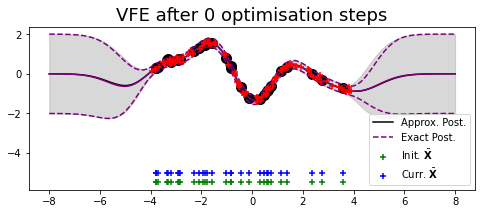

Step: 1000 Free energy:    0.107 Coeff:  1.00 Scales: [1.0] Noise:  0.10


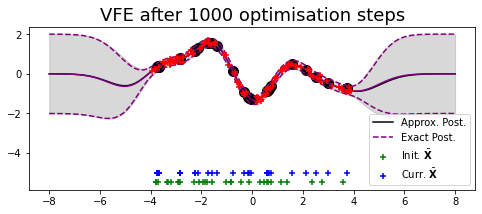

In [267]:
# Set random seed and tensor dtype
tf.random.set_seed(1)
dtype = tf.float64

# Number GP constants
M = 30
inducing_range = (-4., 4.)
log_noise = -2.
log_coeff = 0.
log_scales = [0.]
num_samples = 10

# Define mean and covariance
mean = ConstantMean(dtype=dtype)

cov = EQcovariance(log_coeff=log_coeff,
                   log_scales=log_scales,
                   dim=1,
                   dtype=dtype)

# Initial locations of inducing points
x_ind_dist = tfp.distributions.Uniform(low=inducing_range[0], high=inducing_range[1])
x_ind_init = x_ind_dist.sample(sample_shape=(M, 1))
x_ind_init = tf.cast(x_ind_init, dtype=dtype)

# Define sparse VFEGP
vfe_gp = VFEGP(mean=mean,
               cov=cov,
               log_noise=log_noise,
               x_train=x_train,
               y_train=y_train,
               x_ind_init=x_ind_init,
               dtype=dtype)


num_steps = 1000
optimizer = tf.keras.optimizers.SGD(1e-1, momentum=1e-1)

x_pred = tf.linspace(-8., 8., 100)[:, None]
x_pred = tf.cast(x_pred, dtype=tf.float64)

losses = []

for step in range(num_steps + 1):
    
    with tf.GradientTape() as tape:

        free_energy = vfe_gp.free_energy()
        loss = - free_energy
        
        losses.append(free_energy)
        
        # Print information and plot at start and end
        if step % num_steps == 0:
            
            print_info(vfe_gp, step)

            plot(vfe_gp,
                 ground_truth_cov,
                 x_pred,
                 x_train,
                 y_train,
                 x_ind_init,
                 step)

    gradients = tape.gradient(loss, vfe_gp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vfe_gp.trainable_variables))
    
x_ind_optimised = vfe_gp.x_ind
vfe_scale_optimised = vfe_gp.cov.scales[0]
vfe_coeff_optimised = vfe_gp.cov.coeff

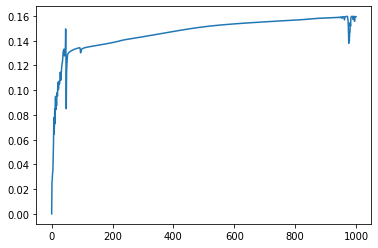

In [253]:
plt.plot(losses)

In [254]:
res1 = 15
res2 = 20
scales = tf.cast(tf.linspace(0.7, 1.3, res1), dtype=dtype)
coeffs = tf.cast(tf.linspace(0.4, 1.3, res2), dtype=dtype)

free_energies = np.zeros(shape=(res1, res2))

for i, scale in enumerate(scales):
    for j, coeff in enumerate(coeffs):
        
        cov = EQcovariance(log_coeff=np.log(coeff),
                           log_scales=[np.log(scale)],
                           dim=1,
                           dtype=dtype)
        
        vfe_gp = VFEGP(mean=mean,
                       cov=cov,
                       log_noise=np.log(0.1),
                       x_train=x_train,
                       y_train=y_train,
                       x_ind_init=x_ind_optimised,
                       dtype=dtype)
        
        free_energies[i, j] = vfe_gp.free_energy().numpy()

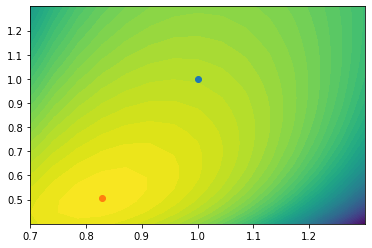

In [255]:
x, y = np.meshgrid(scales, coeffs)

plt.contourf(x, y, free_energies.T, levels=50)
plt.scatter([1.], [1.])
plt.scatter([vfe_scale_optimised.numpy()], [vfe_coeff_optimised.numpy()])
plt.show()